In [50]:
import pandas as pd
import pandas as pd
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from tensorflow.keras.callbacks import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
import sys
sys.path.append('..')
from xDL.models.FTTransformer import FTTransformer
from xDL.utils.data_utils import *

In [52]:


# Set a random seed for reproducibility
np.random.seed(101)

# Number of data points
num_samples = 5000

# Define a list of possible categorical values
categories = ['A', 'B']

# Generate random categorical data as an array of strings
categorical1 = np.random.choice(categories, size=num_samples)

categories = ['Yes', 'No', 'Maybe']
categorical2 = np.random.choice(categories, size=num_samples)

# Generate the input variable X as a random draw from a linspace
X1 = np.random.uniform(1, 10, size=num_samples)
X2 = np.random.uniform(2, 4, size=num_samples)

# Generate continuous variables as a function of X with noise dependent on X
def func1(x):
    x = 5*np.sin(x) 
    return x/6

def func2(x):
    x = (2*(x-3))**2
    return x/6


# Create mappings for categorical values
category_map1 = {'A': 0.5, 'B': -0.5}
category_map2 = {'Yes': 0.5, 'No': -0.5, 'Maybe': 0}

# Calculate y by combining continuous and categorical functions
#
y = func1(X1) - func2(X2)  +  (func1(X1)*func2(X2)) + np.vectorize(category_map1.get)(categorical1) + np.vectorize(category_map2.get)(categorical2) + np.random.normal(0, 0.2, size=num_samples) 


data = pd.DataFrame({"Target": y, 'Category1': categorical1, 'Category2': categorical2, 'Continuous1':X1, 'Continuous2':X2})



In [53]:
EARLY_STOPPING = EarlyStopping(
        patience=15, restore_best_weights=True, min_delta=1e-05, monitor="val_loss"
    )



(array([  37.,  116.,  321.,  481.,  738.,  980., 1013.,  553.,  675.,
          86.]),
 array([-2.78978413, -2.31452606, -1.83926799, -1.36400992, -0.88875185,
        -0.41349378,  0.06176428,  0.53702235,  1.01228042,  1.48753849,
         1.96279656]),
 <BarContainer object of 10 artists>)

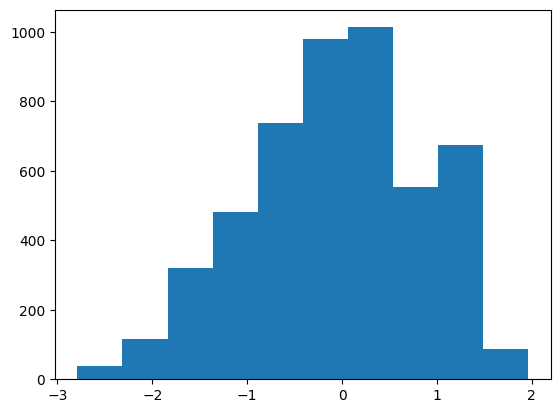

In [54]:
plt.hist(data["Target"])

In [55]:
preds_cont1 = []
preds_cont2 = []

for i in tqdm(range(10)):
    model = FTTransformer(
        data=data, 
        y="Target",
        output_activation="linear",
        binning_task="regression",
        num_encoding="PLE",
        n_bins_num=50,
        batch_size=4096,
        dropout=0.5,
        attn_dropout=0.5,
        ff_dropout=0.5,
        embedding_dim=64
        )
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer = optimizer,
        loss = {"output": "mse", "importances": None, "att_weights": None},
        metrics= {"output": "mse", "importances": None, "att_weights": None},)

    history = model.fit(
        model.training_dataset, 
        epochs=250, 
        validation_data=model.validation_dataset,
        callbacks=[EARLY_STOPPING],
        verbose=0,
    )

    dataset = model.data.copy()
    dataset["Category1"] = np.repeat("UNK", len(dataset))
    dataset["Category2"] = np.repeat("UNK", len(dataset))
    
    dataset["Continuous1"] = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(dataset))
    dataset["Continuous2"] = np.linspace(-30, -10, len(dataset))
    input_dict = model.input_dict.copy()
    input_dict["Continuous2"]["encoding"] = "PLE"
    dataset = df_to_dataset(
                dataset,
                model.data,
                input_dict,
                model.y,
                batch_size=4096,
                shuffle=False,
                feature_information=model.feature_information,
                task=model.binning_task,
    )
    
    
    
    preds = model.predict(dataset, verbose=0)
    preds = preds["output"].squeeze()

    preds_cont1.append(preds)

    del dataset

    dataset = model.data.copy()
    dataset["Category1"] = np.repeat("UNK", len(dataset))
    dataset["Category2"] = np.repeat("UNK", len(dataset))
    
    dataset["Continuous1"] = np.linspace(-30, -10, len(dataset))
    dataset["Continuous2"] = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), len(dataset))
    input_dict = model.input_dict.copy()
    input_dict["Continuous2"]["encoding"] = "PLE"
    dataset = df_to_dataset(
                dataset,
                model.data,
                input_dict,
                model.y,
                batch_size=4096,
                shuffle=False,
                feature_information=model.feature_information,
                task=model.binning_task,
    )
    
    
    
    preds = model.predict(dataset, verbose=0)
    preds = preds["output"].squeeze()

    preds_cont2.append(preds)

    del dataset



100%|██████████| 10/10 [43:55<00:00, 263.55s/it]


In [56]:
dataset = model.data.copy()
dataset["Category1"] = np.repeat("UNK", len(dataset))
dataset["Category2"] = np.repeat("UNK", len(dataset))
dataset["Continuous1"] = np.linspace(-30, -10, len(dataset))
dataset["Continuous2"] = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), len(dataset))
input_dict = model.input_dict.copy()
input_dict["Continuous2"]["encoding"] = "PLE"
dataset = df_to_dataset(
            dataset,
            model.data,
            input_dict,
            model.y,
            batch_size=1024,
            shuffle=False,
            feature_information=model.feature_information,
            task=model.binning_task,
)


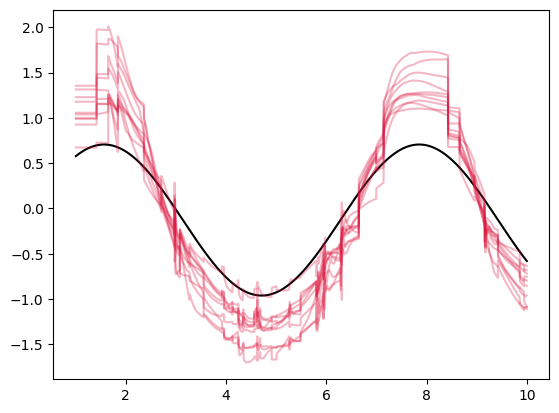

In [57]:
x_pred = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), 500)

plt.plot(x_pred,
        func1(x_pred) - np.mean(func1(x_pred)), 
        color="black"
        )

x_pred = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(preds_cont1[0]))

for pred in preds_cont1:
    plt.plot(
        x_pred,
        pred - np.mean(pred), 
        color="crimson",
        alpha=0.3
        )

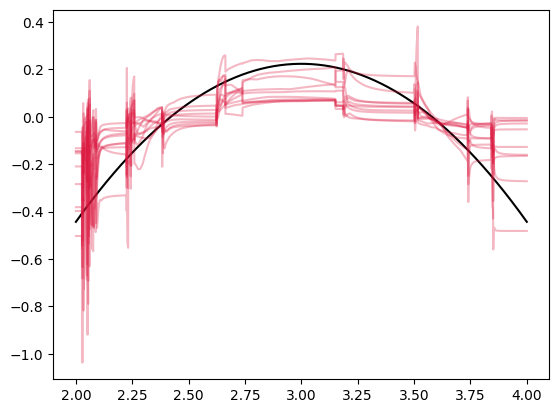

In [58]:
x_pred = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), 500)

plt.plot(x_pred,
        - (func2(x_pred) - np.mean(func2(x_pred))), 
        color="black"
        )

x_pred = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), len(preds_cont2[0]))

for pred in preds_cont2:
    plt.plot(
        x_pred,
        pred - np.mean(pred), 
        color="crimson",
        alpha=0.3
        )

In [59]:
FT_transformer_history = history.history

In [60]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


inputs = [model.input_dict[key]["Input"][0] for key, value in model.input_dict.items()]
# Define the MLP model

x = layers.concatenate(inputs)  # Concatenate all inputs
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1, activation='linear', name='output')(x)


In [61]:
mlp_preds_1 = []
mlp_preds_2 = []
for i in tqdm(range(10)):
    mlp = keras.Model(inputs=inputs, outputs=output)

    # Compile the model
    mlp.compile(optimizer='adam', loss='mse', metrics=['mse'])

    # Train the model on the TensorFlow dataset
    history = mlp.fit(model.training_dataset, validation_data=model.validation_dataset, epochs=100, verbose=0)

    dataset = model.data.copy()
    dataset["Category1"] = np.repeat("UNK", len(dataset))
    dataset["Category2"] = np.repeat("UNK", len(dataset))
    
    dataset["Continuous1"] = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(dataset))
    dataset["Continuous2"] = np.linspace(-30, -10, len(dataset))
    input_dict = model.input_dict.copy()
    input_dict["Continuous2"]["encoding"] = "PLE"
    dataset = df_to_dataset(
                dataset,
                model.data,
                input_dict,
                model.y,
                batch_size=1024,
                shuffle=False,
                feature_information=model.feature_information,
                task=model.binning_task,
    )
    mlp_preds_1.append(mlp.predict(dataset, verbose=0))


    dataset = model.data.copy()
    dataset["Category1"] = np.repeat("UNK", len(dataset))
    dataset["Category2"] = np.repeat("UNK", len(dataset))

    dataset["Continuous1"] = np.linspace(-30, -10, len(dataset))
    dataset["Continuous2"] = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), len(dataset))

    input_dict = model.input_dict.copy()
    input_dict["Continuous2"]["encoding"] = "PLE"
    dataset = df_to_dataset(
                dataset,
                model.data,
                input_dict,
                model.y,
                batch_size=1024,
                shuffle=False,
                feature_information=model.feature_information,
                task=model.binning_task,
    )
    mlp_preds_2.append(mlp.predict(dataset, verbose=0))

100%|██████████| 10/10 [07:56<00:00, 47.69s/it]


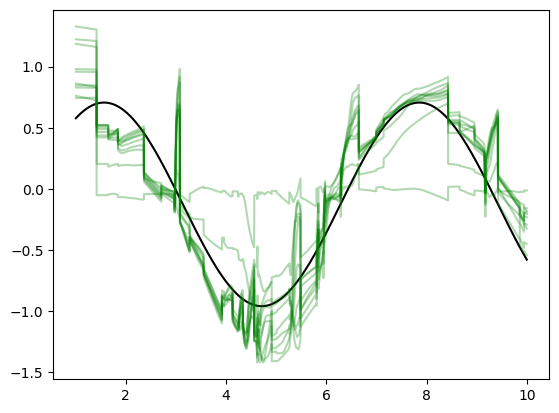

In [62]:
x_pred = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), 500)

plt.plot(x_pred,
        func1(x_pred) - np.mean(func1(x_pred)), 
        color="black"
        )

x_pred = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(mlp_preds_1[0]))

for pred in mlp_preds_1:
    plt.plot(
        x_pred,
        pred - np.mean(pred), 
        color="green",
        alpha=0.3
        )

AttributeError: module 'numpy' has no attribute 'softmax'

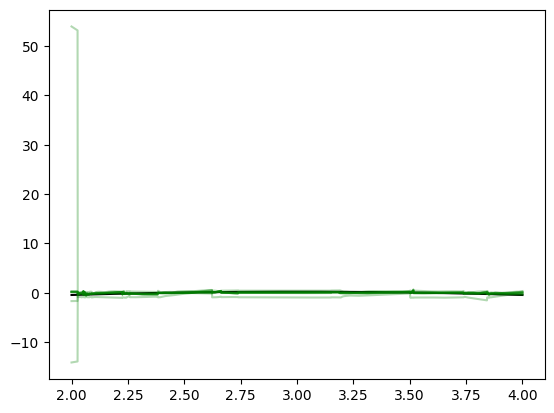

In [63]:
x_pred = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), 500)

plt.plot(x_pred,
        - (func2(x_pred) - np.mean(func2(x_pred))), 
        color="black"
        )

x_pred = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), len(mlp_preds_2[0]))

for pred in mlp_preds_2:
    plt.plot(
        x_pred,
        pred - np.mean(pred), 
        color="green",
        alpha=0.3
        )

In [64]:
embedding_mlp_history = history.history

In [65]:
from xDL.models.NAM import NAM

nam = NAM(
    "Target ~  -1 +  MLP(Continuous1) + MLP(Continuous2) + MLP(Category1) + MLP(Category2)", 
    data=data, 
    feature_dropout=0.0001
    )

inputs = [nam.input_dict[key]["Input"][0] for key, value in nam.input_dict.items()]
# Define the MLP model

x = layers.concatenate(inputs)  # Concatenate all inputs
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1, activation='linear', name='output')(x)


In [66]:
mlp_preds_1_normalized = []
mlp_preds_2_normalized = []
for i in tqdm(range(10)):
    mlp = keras.Model(inputs=inputs, outputs=output)

    # Compile the model
    mlp.compile(optimizer='adam', loss='mse', metrics=['mse'])

    # Train the model on the TensorFlow dataset
    history = mlp.fit(nam.training_dataset, validation_data=nam.validation_dataset, epochs=100, verbose=0)

    dataset = nam.data.copy()
    dataset["Category1"] = np.repeat("UNK", len(dataset))
    dataset["Category2"] = np.repeat("UNK", len(dataset))
    
    dataset["Continuous1"] = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(dataset))
    dataset["Continuous2"] = np.linspace(-30, -10, len(dataset))

    dataset = df_to_dataset(
                dataset,
                nam.data,
                nam.input_dict,
                nam.y,
                batch_size=1024,
                shuffle=False,
                feature_information=nam.feature_information,
                task=nam.binning_task,
    )
    mlp_preds_1_normalized.append(mlp.predict(dataset, verbose=0))


    dataset = nam.data.copy()
    dataset["Category1"] = np.repeat("UNK", len(dataset))
    dataset["Category2"] = np.repeat("UNK", len(dataset))

    dataset["Continuous1"] = np.linspace(-30, -10, len(dataset))
    dataset["Continuous2"] = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), len(dataset))

    dataset = df_to_dataset(
                dataset,
                nam.data,
                input_dict,
                nam.y,
                batch_size=1024,
                shuffle=False,
                feature_information=nam.feature_information,
                task=nam.binning_task,
    )
    mlp_preds_2_normalized.append(mlp.predict(dataset, verbose=0))

100%|██████████| 10/10 [04:04<00:00, 24.48s/it]


In [67]:
normalized_mlp_history = history.history

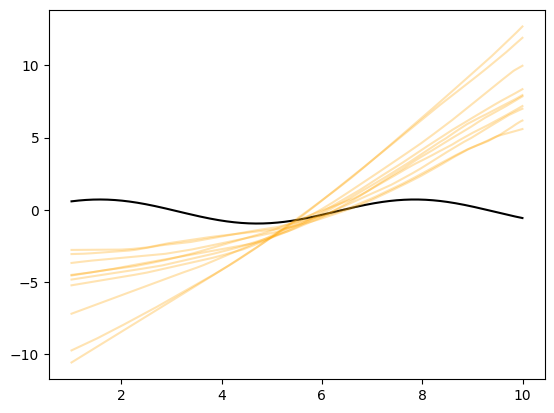

In [68]:
x_pred = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), 500)

plt.plot(x_pred,
        func1(x_pred) - np.mean(func1(x_pred)), 
        color="black"
        )

x_pred = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(mlp_preds_1[0]))

for pred in mlp_preds_1_normalized:
    plt.plot(
        x_pred,
        pred - np.mean(pred), 
        color="orange",
        alpha=0.3
        )
    
    

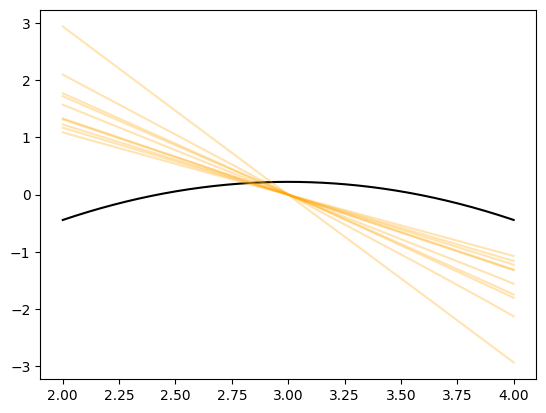

In [69]:
x_pred = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), 500)

plt.plot(x_pred,
        - (func2(x_pred) - np.mean(func2(x_pred))), 
        color="black"
        )

x_pred = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), len(mlp_preds_1[0]))

for pred in mlp_preds_2_normalized:
    plt.plot(
        x_pred,
        pred - np.mean(pred), 
        color="orange",
        alpha=0.3
        )

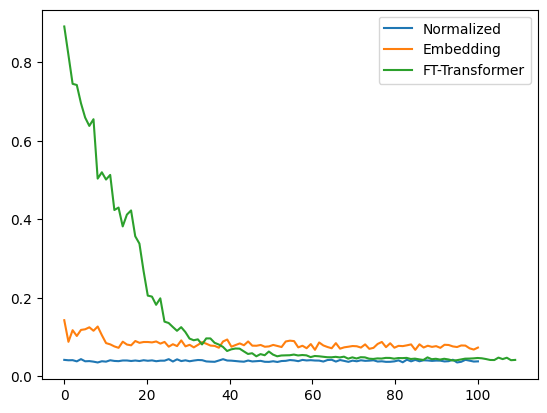

In [70]:
plt.plot(np.linspace(0, len(normalized_mlp_history["val_loss"]), len(normalized_mlp_history["val_loss"])), normalized_mlp_history["val_loss"], label="Normalized")
plt.plot(np.linspace(0, len(embedding_mlp_history["val_loss"]), len(embedding_mlp_history["val_loss"])), embedding_mlp_history["val_loss"], label="Embedding")
plt.plot(np.linspace(0, len(FT_transformer_history["val_loss"]), len(FT_transformer_history["val_loss"])), FT_transformer_history["val_loss"], label="FT-Transformer")
plt.legend()

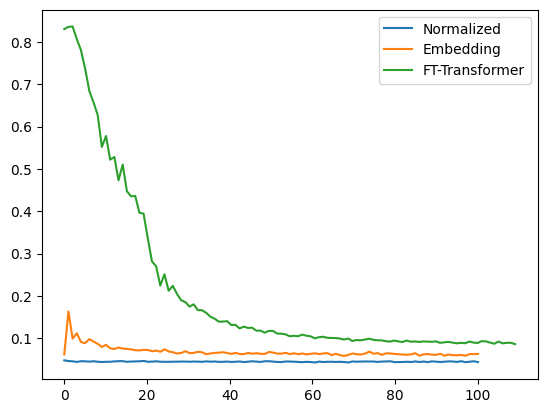

In [71]:
plt.plot(np.linspace(0, len(normalized_mlp_history["loss"]), len(normalized_mlp_history["loss"])), normalized_mlp_history["loss"], label="Normalized")
plt.plot(np.linspace(0, len(embedding_mlp_history["loss"]), len(embedding_mlp_history["loss"])), embedding_mlp_history["loss"], label="Embedding")
plt.plot(np.linspace(0, len(FT_transformer_history["loss"]), len(FT_transformer_history["loss"])), FT_transformer_history["loss"], label="FT-Transformer")
plt.legend()

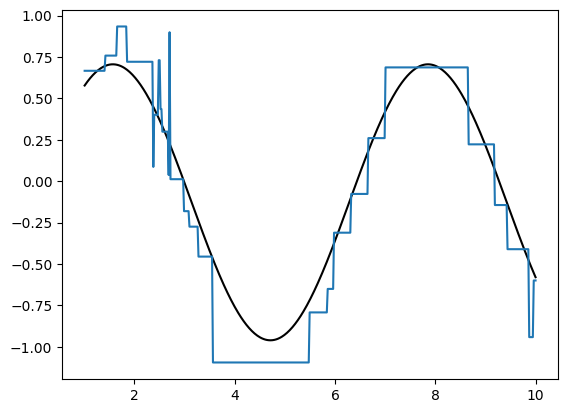

In [72]:
from sklearn import tree

clf = tree.DecisionTreeRegressor(max_depth=5)
clf = clf.fit(np.expand_dims(nam.data["Continuous1"], 1), nam.data["Target"])


x_pred = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), 500)

plt.plot(x_pred,
        func1(x_pred) - np.mean(func1(x_pred)), 
        color="black"
        )

tree_preds = clf.predict(x_pred.reshape(-1, 1))

plt.plot(x_pred, tree_preds)

In [73]:
MLP = [
{"ll": -1070.6843078577226, "AUC": 0.6885132193565369, "CRPS": 0.3289978814770082, "Wasserstein": 0.10345172273146709},
{"ll": -1067.5985623677207, "AUC": 0.6916993856430054, "CRPS": 0.30714608599874355, "Wasserstein": 0.10289220846588634},
{"ll": -1135.451248161674,  "AUC": 0.6703908443450928, "CRPS": 0.30469139561987113, "Wasserstein": 0.11734437332360138},
{"ll": -1100.5301598551932, "AUC": 0.6985498070716858, "CRPS": 0.2941013478610752,  "Wasserstein": 0.12925336310219793},
{"ll": -1083.2653747180975, "AUC": 0.7078884840011597, "CRPS": 0.29903582056053923, "Wasserstein": 0.10042076265958261}
]

auc = []
crps = []

for result in MLP:
    auc.append(result["AUC"])
    crps.append(result["CRPS"])

print("AUC", np.mean(auc), np.std(auc))

print("CRPS", np.mean(crps), np.std(crps))

AUC 0.691408348083496 0.012432194118056294
CRPS 0.3067945063034475 0.01199041306734496


In [74]:
MLP = [
{"LL": 30461.123481910796, "Gamma Deviance": 1.4265202021852696, "KL_Div": 5.741150856018066,   "Wasserstein Distance": 152.0165409071228},
{"LL": 35318.20174744948,  "Gamma Deviance": 1.2835454475191859, "KL_Div": 6.2148213386535645,  "Wasserstein Distance": 221.8048640849841},
{"LL": 61261.48058612945,  "Gamma Deviance": 0.8159966766728369, "KL_Div": 5.578059196472168,   "Wasserstein Distance": 123.9700941103825},
{"LL": 49589.55836062774,  "Gamma Deviance": 0.5038153472756847, "KL_Div": 2.8479347229003906,  "Wasserstein Distance": 79.83697441227298},
{"LL": 58758.86867843733,  "Gamma Deviance": 420308.43175023096, "KL_Div": 5.23057746887207,    "Wasserstein Distance": 99.68177936169673},
]
XGBOOST = [
{"LL": 21736.914479152172, "Gamma Deviance": 1.811586591010074,  "KL_Div": 5.797798156738281,  "Wasserstein Distance": 92.579975289326},
{"LL": 22811.95628244244,  "Gamma Deviance": 1.4933338484342384, "KL_Div": 6.06115198135376,   "Wasserstein Distance": 162.07144292665},
{"LL": 21918.92829014237,  "Gamma Deviance": 0.8289743108852833, "KL_Div": 5.820164680480957,  "Wasserstein Distance": 91.060918811926},
{"LL": 65517.231145916856, "Gamma Deviance": 0.4227081907830405, "KL_Div": 2.910442352294922,  "Wasserstein Distance": 44.738689653135},
{"LL": 21393.4501774495,   "Gamma Deviance": 0.883270382354246,  "KL_Div": 5.580944538116455,  "Wasserstein Distance": 87.670394057640},
]
NAM = [
{"LL": 31026.240535700086, "Gamma Deviance": 6.588611168352721e+26,  "KL_Div": 5.676055908203125,  "Wasserstein Distance": 122.2093537519681},
{"LL": 39959.847163532264, "Gamma Deviance": 11040937685759.709,     "KL_Div": 6.009641647338867,  "Wasserstein Distance": 182.5368869272447},
{"LL": 89191.32440803378,  "Gamma Deviance": 8.90900899573191e+23,   "KL_Div": 5.432011127471924,  "Wasserstein Distance": 122.9494378103765},
{"LL": 92327.04728972483,  "Gamma Deviance": 2.3333869801891646e+34, "KL_Div": 0.8604879379272461, "Wasserstein Distance": 81.78049013779923},
{"LL": 68218.55415449354,  "Gamma Deviance": 1.3366837156509953e+28, "KL_Div": 5.049967288970947,  "Wasserstein Distance": 104.7091434848576},
]
EBM = [
{"LL": 20693.999989126223, "Gamma Deviance": 2.340313366589651,   "KL_Div": 5.8892903327941895, "Wasserstein Distance": 101.1040105727893},
{"LL": 21161.118512540277, "Gamma Deviance": 1.4276374880403713,  "KL_Div": 6.125360012054443,  "Wasserstein Distance": 169.1336823528308},
{"LL": 20577.34733043096,  "Gamma Deviance": 0.830883147510835,   "KL_Div": 5.900798320770264,  "Wasserstein Distance": 99.01718914566335},
{"LL": 20506.34698397163,  "Gamma Deviance": 0.43156458967501937, "KL_Div": 4.339306831359863,  "Wasserstein Distance": 56.04949406247272},
{"LL": 20581.501926164827, "Gamma Deviance": 1.0005533011953898,  "KL_Div": 5.672048568725586,  "Wasserstein Distance": 95.60727087343008},
]
NodeGAM = [
{"LL": 20927.51402350536,  "Gamma Deviance": 1.8029946529358107,  "KL_Div": 5.937500476837158,  "Wasserstein Distance": 105.5309228544922},
{"LL": 21554.94319188159,  "Gamma Deviance": 1.4246843611349638,  "KL_Div": 6.179159641265869,  "Wasserstein Distance": 175.6971454456948},
{"LL": 20806.347456287196, "Gamma Deviance": 0.8240429463804008,  "KL_Div": 5.954611778259277,  "Wasserstein Distance": 103.0801700812959},
{"LL": 20915.539379606038, "Gamma Deviance": 0.46084586311467424, "KL_Div": 4.517280101776123,  "Wasserstein Distance": 59.95013495145368},
{"LL": 21034.213885520865, "Gamma Deviance": 1.0364598159634948,  "KL_Div": 5.734802722930908,  "Wasserstein Distance": 100.7815988046894},
]
DDNN = [
{"LL": 21005.392578125, "Gamma Deviance": 0.9427362527381409, "KL_Div": 5.185816287994385,    "Wasserstein Distance": 256.3892229893356},
{"LL": 21107.509765625, "Gamma Deviance": 1.5397546057358935, "KL_Div": 5.602282524108887,    "Wasserstein Distance": 323.2088847698095},
{"LL": 20800.59765625,  "Gamma Deviance": 0.9438089378369443, "KL_Div": 5.253805160522461,    "Wasserstein Distance": 252.7060651638590},
{"LL": 20962.47265625,  "Gamma Deviance": 0.6046442588763653, "KL_Div": 0.20796313881874084,  "Wasserstein Distance": 209.0377017649561},
{"LL": 20948.142578125, "Gamma Deviance": 0.9039238698214761, "KL_Div": 4.783555030822754,    "Wasserstein Distance": 245.4893254976948},
]
NAMLSS = [
{"LL": 21027.810546875, "Gamma Deviance": 0.9428572697443661, "KL_Div": 5.278640270233154,   "Wasserstein Distance": 256.524007712016},
{"LL": 21109.876953125, "Gamma Deviance": 1.438631215449061,  "KL_Div": 5.63920259475708,    "Wasserstein Distance": 323.4634145309858},
{"LL": 20817.95703125,  "Gamma Deviance": 0.941867120243056,  "KL_Div": 5.30327844619751,    "Wasserstein Distance": 252.8180529182798},
{"LL": 20960.509765625, "Gamma Deviance": 0.5920665840285994, "KL_Div": 0.08997141569852829, "Wasserstein Distance": 209.0753436502833},
{"LL": 20950.43359375,  "Gamma Deviance": 0.8940982380585505, "KL_Div": 4.842281341552734,   "Wasserstein Distance": 245.6910390848589},
]
NA2MLSS = [
{"LL": 21012.275390625, "Gamma Deviance": 0.9631384124588139, "KL_Div": 5.190236568450928,    "Wasserstein Distance": 256.3234433919321},
{"LL": 21116.404296875, "Gamma Deviance": 1.4571833882826504, "KL_Div": 5.597091197967529,    "Wasserstein Distance": 323.3431970783661},
{"LL": 20802.025390625, "Gamma Deviance": 0.9477549438127629, "KL_Div": 5.250584602355957,    "Wasserstein Distance": 252.6556458194882},
{"LL": 20942.94140625,  "Gamma Deviance": 0.566198791738851,  "KL_Div": 0.09349526464939117,  "Wasserstein Distance": 208.9275884648724},
{"LL": 20944.62109375,  "Gamma Deviance": 0.8947400708107456, "KL_Div": 4.783163070678711,    "Wasserstein Distance": 245.5623735843248},
]


In [75]:
my_models = ["MLP", "XGBOOST", "NAM", "EBM", "NodeGAM", "DDNN", "NAMLSS", "NA2MLSS"]
mylist = [MLP, XGBOOST, NAM, EBM, NodeGAM, DDNN, NAMLSS, NA2MLSS]

for name, model_ in zip(my_models, mylist):
    auc = []
    crps = []

    for result in model_:

        auc.append(result["Gamma Deviance"])
        crps.append(result["KL_Div"])

    print(name, "Gamma :", np.round(np.mean(auc), 3), np.round(np.std(auc),3), "KL:", np.round(np.mean(crps),2), np.round(np.std(crps), 2))


MLP Gamma : 84062.492 168122.97 KL: 5.12 1.18
XGBOOST Gamma : 1.088 0.498 KL: 5.23 1.17
NAM Gamma : 4.666776765696164e+33 9.333546518099134e+33 KL: 4.61 1.9
EBM Gamma : 1.206 0.651 KL: 5.59 0.64
NodeGAM Gamma : 1.11 0.466 KL: 5.66 0.59
DDNN Gamma : 0.987 0.304 KL: 4.21 2.02
NAMLSS Gamma : 0.962 0.272 KL: 4.23 2.09
NA2MLSS Gamma : 0.966 0.285 KL: 4.18 2.06
